In [5]:
#  python setup.py develop <--- useful for if you're developing and changing code
from matplotlib import pyplot
%matplotlib inline
import readMXXL as rm

In [6]:
# Read in mxxl data with the specified reader
simreader = rm.MXXLSimReader()
loaded_catalog = simreader.load('/home/babyostrich/data/mxxl/halo_54_100_0')

Loading /home/babyostrich/data/mxxl/halo_54_100_0


In [7]:
# Show loaded catalog properties
print loaded_catalog.x_mpc
print loaded_catalog.gamma1_inf
print loaded_catalog.gamma1_inf.size

[-5.66022709 -5.66022709 -5.66022709 ...,  5.66022709  5.66022709
  5.66022709]
[-0.00196354 -0.00123814 -0.00083659 ...,  0.00610671  0.00536575
  0.00412299]
4194304


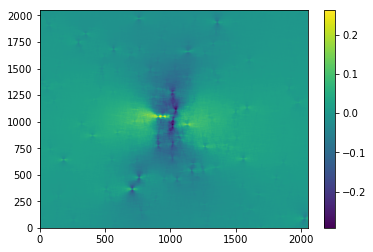

In [8]:
# Visualize the gamma field
import numpy as np
reshape_size=int(np.sqrt(loaded_catalog.gamma1_inf.size))
gamma1_inf = loaded_catalog.gamma1_inf.reshape((reshape_size,reshape_size))
pyplot.pcolormesh(gamma1_inf)
pyplot.colorbar()
pyplot.show()

In [40]:
# Read in a sample config file and build the profile from specified configuration
import simutils
config = simutils.readConfiguration('sampleconfig.py')

In [41]:
# Load the simreader specified in the config
simreader_from_configfile = config['simreader']
loaded_sim_from_config = simreader_from_configfile.load('/home/babyostrich/data/mxxl/halo_54_100_0')

# Build the profile with builder specified from config
profilebuilder_from_config = config['profilebuilder']
profile_of_sim_from_config = profilebuilder_from_config(loaded_sim_from_config)

Loading /home/babyostrich/data/mxxl/halo_54_100_0
Center Offset: 0.175714307486 -0.0859140398324


In [11]:
# These are the available fields
print profile_of_sim_from_config.table.keys()

['sigma_ghat', 'beta_s', 'ngals', 'r_mpc', 'ghat', 'beta_s2']


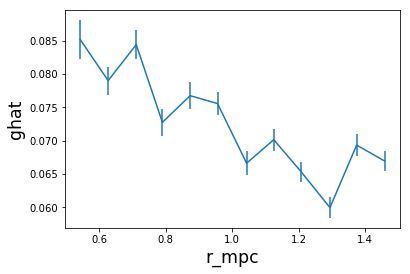

In [42]:
profile_of_sim_from_config.table['r_mpc'] #center of radial bins
pyplot.errorbar(profile_of_sim_from_config.table['r_mpc'], profile_of_sim_from_config.table['ghat'], 
                yerr=profile_of_sim_from_config.table['sigma_ghat'])
pyplot.xlabel('r_mpc',fontsize='xx-large')
pyplot.ylabel('ghat',fontsize='xx-large')
pyplot.show()

Loading /home/babyostrich/data/mxxl/halo_54_100_0
Center Offset: 0.109895568786 -0.370440669789
Center Offset: 0.0 0.0


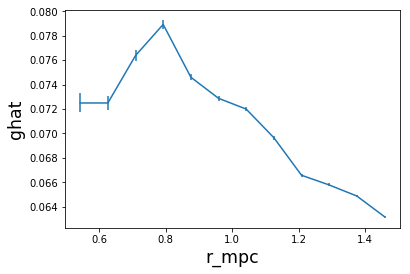

In [13]:
# Now we do the same with an "ideal" config
config = simutils.readConfiguration('idealsampleconfig.py')
simreader_from_configfile = config['simreader']
loaded_sim_from_config = simreader_from_configfile.load('/home/babyostrich/data/mxxl/halo_54_100_0')
profile_of_sim_from_config = profilebuilder_from_config(loaded_sim_from_config)
profilebuilder_from_config = config['profilebuilder']
profile_of_sim_from_config = profilebuilder_from_config(loaded_sim_from_config)
pyplot.errorbar(profile_of_sim_from_config.table['r_mpc'], profile_of_sim_from_config.table['ghat'], 
            yerr=profile_of_sim_from_config.table['sigma_ghat'])
pyplot.xlabel('r_mpc',fontsize='xx-large')
pyplot.ylabel('ghat',fontsize='xx-large')
pyplot.show()

In [32]:
# Let's try fitting the data
def model_reduced_shear( const_args, mass15, cdelta ) :
    from nfwmodeltools import NFWKappa, NFWShear
    import numpy as np
    
    mass = mass15 * 1e15
    (r, avg_beta, avg_beta2, rho_c, rho_c_sigma_c, delta) = const_args
    
    rdelta =(3*abs(mass)/(4*delta*np.pi*rho_c))**(1./3.)
    rscale = rdelta / cdelta
    kappa_inf = NFWKappa(r, cdelta, rscale, rho_c_over_sigma_c, delta = delta)
    gamma_inf = NFWShear(r, cdelta, rscale, rho_c_over_sigma_c, delta = delta)
    
    return avg_beta * gamma_inf / (1 - kappa_inf * avg_beta2/avg_beta)

In [33]:
print profile_of_sim_from_config.table.keys()
print profile_of_sim_from_config.zcluster

['sigma_ghat', 'beta_s', 'ngals', 'r_mpc', 'ghat', 'beta_s2']
0.242469090916


In [43]:
avg_beta = profile_of_sim_from_config.table['beta_s']
avg_beta2 = profile_of_sim_from_config.table['beta_s2']

from nfwutils import global_cosmology
zcluster = profile_of_sim_from_config.zcluster
rho_c = global_cosmology.rho_crit(zcluster)
# note: global_cosmology.beta([1e6], zcluster) is beta at effectively infinite redshift
rho_c_sigma_c = 1.5 * global_cosmology.angulardist(zcluster) * \
    global_cosmology.beta([1e6], zcluster)[0] * global_cosmology.hubble2(zcluster) / \
            global_cosmology.v_c**2
delta=200

x_data = (profile_of_sim_from_config.table['r_mpc'], 
          avg_beta, avg_beta2, rho_c, rho_c_sigma_c, delta)
y_data = profile_of_sim_from_config.table['ghat']
sigma = profile_of_sim_from_config.table['sigma_ghat']
print x_data

(array([ 0.54207963,  0.62640938,  0.7110304 ,  0.78976855,  0.87349112,
        0.95577336,  1.04338338,  1.12528613,  1.20831646,  1.29452169,
        1.37488958,  1.45890322]), array([ 0.38262839,  0.38262839,  0.38262839,  0.38262839,  0.38262839,
        0.38262839,  0.38262839,  0.38262839,  0.38262839,  0.38262839,
        0.38262839,  0.38262839]), array([ 0.14640448,  0.14640448,  0.14640448,  0.14640448,  0.14640448,
        0.14640448,  0.14640448,  0.14640448,  0.14640448,  0.14640448,
        0.14640448,  0.14640448]), 173483877965.92105, 7.6540848512401328e-05, 200)


In [44]:
# Let's fit
from scipy.optimize import curve_fit
popt, pcov = curve_fit(model_reduced_shear, x_data, y_data, sigma=sigma)

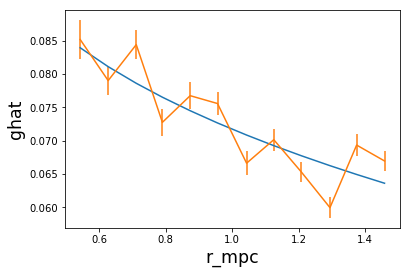

In [45]:
pyplot.plot(profile_of_sim_from_config.table['r_mpc'], model_reduced_shear( x_data, *popt ))
pyplot.errorbar(profile_of_sim_from_config.table['r_mpc'], profile_of_sim_from_config.table['ghat'], 
            yerr=profile_of_sim_from_config.table['sigma_ghat'])
pyplot.xlabel('r_mpc',fontsize='xx-large')
pyplot.ylabel('ghat',fontsize='xx-large')

In [47]:
popt, pcov

(array([ 21.72741268,   1.35173959]), array([[ 53.52393335,  -2.38094432],
        [ -2.38094432,   0.1070001 ]]))

In [88]:
# Let's create a directed acyclic graph: Baysian Network to do the analog to curve_fit
# with pymc, taking into account prior distributions.
import pymc
mass15 = pymc.Uniform('mass15',0.01, 150)
concentration = pymc.Uniform('concentration',1., 15.)

@pymc.deterministic(trace=False)  # Applies to gmodel in the next line
def gmodel(x_data=x_data, mass15=mass15, concentration=concentration) :
    return model_reduced_shear(x_data, mass15, concentration)

gsigma = sigma  # This *could* be a probability distribution
tau = 1./gsigma**2
# @pymc.observed <---- this is needed if the next line is a function 
# that calculates likelihood and returns the log probability
gobserved = pymc.Normal('gobserved', mu=gmodel, tau=tau, value=y_data, observed=True)

In [89]:
# Let's create a pymc model object from the nodes of the graph
pymc_model = pymc.Model([mass15, concentration, gmodel, gobserved])

In [90]:
# Print initial values
print mass15.value, concentration.value

149.389279833 4.16911286154


In [91]:
# Print log probability of the Bayesian network
print pymc_model.logp

-16403308.7574


In [92]:
# We can manually change the values and see how the log prob changes (e.g. more reasonable mass, and larger logp) 
mass15.value = 1.
print pymc_model.logp

-3965.00913127


In [108]:
# We can find parameters that maximize log prob of the network
pymc_maximum_aposteriori = pymc.MAP(pymc_model)
pymc_maximum_aposteriori.fit()
print mass15.value, concentration.value
print gmodel.value

23.08785318 1.2936343155
[ 0.0834667   0.08072802  0.07831961  0.07630717  0.07435523  0.07258847
  0.07084246  0.06931572  0.06785668  0.06642375  0.06515391  0.06388702]


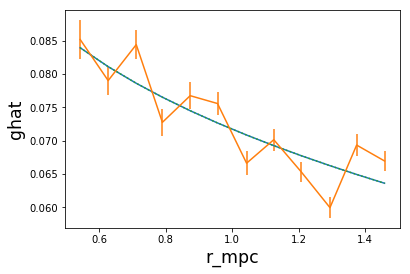

In [94]:
# Let's compare with the data

pyplot.plot(profile_of_sim_from_config.table['r_mpc'], model_reduced_shear( x_data, mass15.value, concentration.value ))
pyplot.errorbar(profile_of_sim_from_config.table['r_mpc'], profile_of_sim_from_config.table['ghat'], 
            yerr=profile_of_sim_from_config.table['sigma_ghat'])
pyplot.plot(profile_of_sim_from_config.table['r_mpc'], gmodel.value, ls=":")
pyplot.xlabel('r_mpc',fontsize='xx-large')
pyplot.ylabel('ghat',fontsize='xx-large')

In [95]:
#  Let's now explore the full posterior without making any normal approximations, etc.
pymc_MCMC = pymc.MCMC(pymc_model)
# Let's run for 1000 iterations
pymc_MCMC.sample(1000)

 [-----------------100%-----------------] 1000 of 1000 complete in 0.1 sec

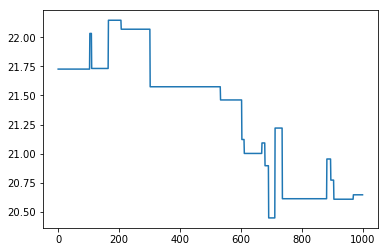

In [96]:
# We want to plot a value vs. steps in chain.  Note -this has not yet converged
pyplot.plot(pymc_MCMC.trace('mass15')[:])

In [99]:
# Let's run for longer now
pymc_MCMC.sample(100000)


 [-----------------100%-----------------] 100000 of 100000 complete in 10.4 sec

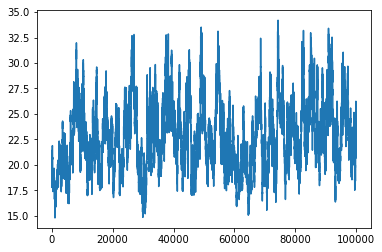

In [100]:
pyplot.plot(pymc_MCMC.trace('mass15')[:])

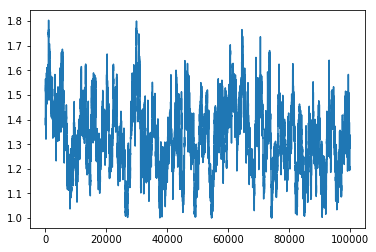

In [102]:
pyplot.plot(pymc_MCMC.trace('concentration')[:])

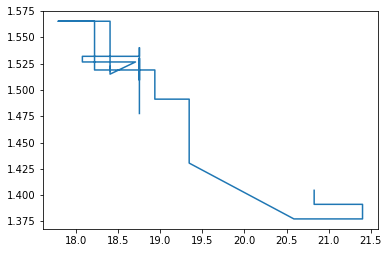

In [105]:
pyplot.plot(pymc_MCMC.trace('mass15')[:100], pymc_MCMC.trace('concentration')[:100])

(array([[  0.,   0.,   0., ...,  10.,  23.,  10.],
        [  0.,   0.,   0., ...,  18.,   4.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ..., 
        [ 23.,   5.,   0., ...,   0.,   0.,   0.],
        [  2.,   2.,   0., ...,   0.,   0.,   0.],
        [  2.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([ 14.79110147,  15.17916485,  15.56722823,  15.95529162,
         16.343355  ,  16.73141838,  17.11948176,  17.50754515,
         17.89560853,  18.28367191,  18.6717353 ,  19.05979868,
         19.44786206,  19.83592545,  20.22398883,  20.61205221,
         21.0001156 ,  21.38817898,  21.77624236,  22.16430575,
         22.55236913,  22.94043251,  23.3284959 ,  23.71655928,
         24.10462266,  24.49268605,  24.88074943,  25.26881281,
         25.6568762 ,  26.04493958,  26.43300296,  26.82106635,
         27.20912973,  27.59719311,  27.9852565 ,  28.37331988,
         28.76138326,  29.14944665,  29.53751003,  29.92557341,
         30.3136368 ,  30.70170018,  3

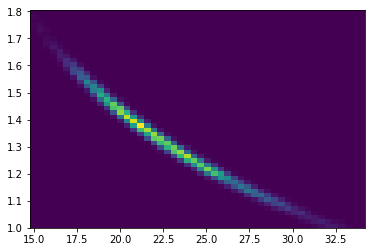

In [106]:
#  We are now plotting P(M, c | ghat )
pyplot.hist2d(pymc_MCMC.trace('mass15')[:], pymc_MCMC.trace('concentration')[:], bins=50)

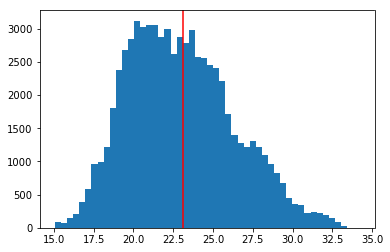

In [112]:
pyplot.hist(pymc_MCMC.trace('mass15')[30000:], bins=50)
pyplot.axvline(mass15.value, c='r')